In [1]:
from recommender_pipeline.data_loaders import  artist_match
import pandas as pd

In [2]:
#  load artists.dat data
artist_df = pd.read_csv('../data/artists.dat', sep='\t', index_col='id')
display(artist_df.head())
print(artist_df.shape)
print(F"Number of unique artist names: {artist_df['name'].nunique()}")

,name,url,pictureURL
id,,,
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


(17632, 3)
Number of unique artist names: 17632


In [3]:
spotify_df = pd.read_parquet('../data/spotify_musics.parquet')
display(spotify_df.head())
print(spotify_df.shape)
print(F"Number of unique artist names: {spotify_df['artist_name'].nunique()}")

,artist_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,Gen Hoshino,Comedy,73.0,230666,0.0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,Ben Woodward,Ghost - Acoustic,55.0,149610,0.0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,Ingrid Michaelson;ZAYN,To Begin Again,57.0,210826,0.0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,Kina Grannis,Can't Help Falling In Love,71.0,201933,0.0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,Chord Overstreet,Hold On,82.0,198853,0.0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


(3528311, 18)
Number of unique artist names: 329401


In [4]:
#drop duplicates
spotify_df.drop_duplicates(subset=['artist_name'], inplace=True)
print(spotify_df.shape)
print(F"Number of unique artist names: {spotify_df['artist_name'].nunique()}")

(329401, 18)
Number of unique artist names: 329401


In [6]:
matched_artists = artist_match.match_data_by_artist(
    left=  artist_df[['name']].reset_index().rename(columns={'id':'artist_id'}),
    right=spotify_df[['artist_name']].reset_index().rename(columns={'index':'spotify_id'}),
    left_artist_col="name",
    right_artist_col="artist_name",
    score_cutoff=80
)

In [9]:
matched_artists.isnull().sum()

artist_id                  0
name                       0
right_spotify_id        2663
right_artist_name       2663
right_matched_artist    2663
right_match_score       2663
dtype: int64

In [10]:
matched_artists.isnull().sum() / len(matched_artists)

artist_id               0.000000
name                    0.000000
right_spotify_id        0.151032
right_artist_name       0.151032
right_matched_artist    0.151032
right_match_score       0.151032
dtype: float64

<Axes: >

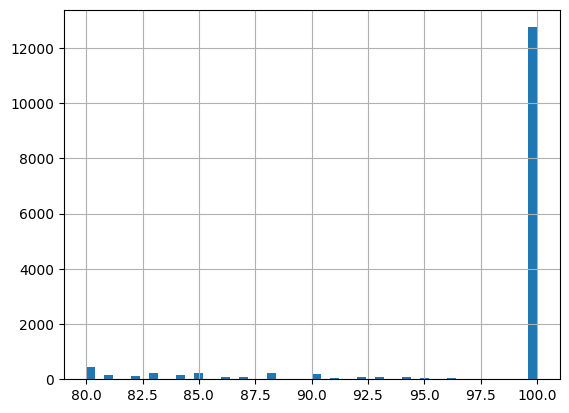

In [11]:
matched_artists.right_match_score.hist(bins=50)

In [12]:
matched_artists.head(10)

,artist_id,name,right_spotify_id,right_artist_name,right_matched_artist,right_match_score
0,1,MALICE MIZER,<NA>,<NA>,<NA>,<NA>
1,2,Diary of Dreams,141558,Diary Of Dreams,Diary Of Dreams,100
2,3,Carpathian Forest,6398,Carpathian Forest,Carpathian Forest,100
3,4,Moi dix Mois,<NA>,<NA>,<NA>,<NA>
4,5,Bella Morte,133253,Bella Morte,Bella Morte,100
5,6,Moonspell,5691,Moonspell,Moonspell,100
6,7,Marilyn Manson,2097,Marilyn Manson,Marilyn Manson,100
7,8,DIR EN GREY,452992,DIR EN GREY,DIR EN GREY,100
8,9,Combichrist,55182,Combichrist,Combichrist,100
9,10,Grendel,55115,Grendel,Grendel,100


In [13]:
matched_artists.to_parquet('../data/matched_artists.parquet', index=False)